In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime
from datetime import timedelta
from prophet import Prophet
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random

In [2]:

# List of sectors and their respective ticker symbols
sectors = {
    'Energy': '^AXEJ',
    'Materials': '^AXMJ',
    'Industrials': '^AXNJ',
    'Consumer Discretionary': '^AXDJ',
    'Consumer Staples': '^AXSJ',
    'Health Care': '^AXHJ',
    'Financials': '^AXFJ',
    'Information Technology': '^AXIJ',
    'Communication Services': '^AXTJ',
    'Utilities': '^AXUJ',
    'Real Estate': '^AXPJ'
}

# Define the date range
end_date = "2023-06-30"  # Today's date
start_date = (datetime.strptime(end_date, '%Y-%m-%d') - pd.DateOffset(years=5)).strftime('%Y-%m-%d')  # Date 5 years before the end_date

# Download data for all tickers over the specified date range
data = yf.download(list(sectors.values()), start=start_date, end=end_date)


# Extract the 'Close' data for all tickers
close_data = data['Close']


# Display the closing prices
print(close_data)


[*********************100%***********************]  11 of 11 completed
                  ^AXDJ         ^AXEJ        ^AXFJ         ^AXHJ        ^AXIJ  \
Date                                                                            
2018-07-02  2440.000000  11941.000000  6197.000000  30366.800781  1129.300049   
2018-07-03  2463.500000  12052.200195  6253.700195  30708.099609  1133.400024   
2018-07-04  2459.800049  12006.900391  6207.500000  30593.099609  1126.900024   
2018-07-05  2459.199951  12048.400391  6269.700195  30726.400391  1122.900024   
2018-07-06  2470.500000  12201.299805  6343.700195  30853.900391  1123.500000   
...                 ...           ...          ...           ...          ...   
2023-06-23  2863.100098  10614.900391  6085.200195  41490.500000  1750.300049   
2023-06-26  2860.399902  10605.000000  6055.000000  41250.398438  1765.699951   
2023-06-27  2861.000000  10627.500000  6094.700195  41200.898438  1759.199951   
2023-06-28  2922.199951  10754.700195 

In [3]:
daily_returns = close_data.pct_change()
cumprod = (1+daily_returns).cumprod()
final_df = cumprod.iloc[-1]
final_df.sort_values()

^AXEJ    0.903417
^AXPJ    0.960164
^AXFJ    1.002727
^AXUJ    1.064989
^AXNJ    1.146523
^AXSJ    1.189669
^AXDJ    1.203074
^AXHJ    1.363937
^AXMJ    1.474104
^AXTJ    1.558498
^AXIJ    1.606659
Name: 2023-06-29 00:00:00, dtype: float64

In [4]:
investment_df = final_df.sort_values().iloc[-4:].index.values
investment_df

array(['^AXHJ', '^AXMJ', '^AXTJ', '^AXIJ'], dtype=object)

In [5]:
weights = [.25, .25, .25, .25]
initial_investment = 100000

In [6]:
final_returns_df = daily_returns[investment_df].dropna()
final_returns_df

,^AXHJ,^AXMJ,^AXTJ,^AXIJ
Date,,,,
2018-07-03,0.011239,-0.014306,0.021410,0.003631
2018-07-04,-0.003745,-0.001530,0.005365,-0.005735
2018-07-05,0.004357,-0.002281,0.016996,-0.003550
2018-07-06,0.004150,0.011240,0.013991,0.000534
2018-07-09,-0.004369,0.010983,0.002396,-0.000534
...,...,...,...,...
2023-06-23,-0.006572,-0.012363,-0.004174,-0.011911
2023-06-26,-0.005787,-0.002352,-0.000720,0.008798
2023-06-27,-0.001200,0.011615,-0.006488,-0.003681


In [7]:
final_portfolio = final_returns_df.dot(weights)
final_portfolio

Date
2018-07-03    0.005494
2018-07-04   -0.001411
2018-07-05    0.003881
2018-07-06    0.007479
2018-07-09    0.002119
                ...   
2023-06-23   -0.008755
2023-06-26   -0.000015
2023-06-27    0.000061
2023-06-28    0.008623
2023-06-29    0.003375
Length: 1264, dtype: float64

In [8]:
#Reset the index in final portfolio
final_portfolio_df = final_portfolio.reset_index()
final_portfolio_df

,Date,0
0,2018-07-03,0.005494
1,2018-07-04,-0.001411
2,2018-07-05,0.003881
3,2018-07-06,0.007479
4,2018-07-09,0.002119
...,...,...
1259,2023-06-23,-0.008755
1260,2023-06-26,-0.000015
1261,2023-06-27,0.000061
1262,2023-06-28,0.008623


In [9]:
# Rename the columns to accommodate prophet
final_portfolio_df.columns = ['ds','y']
final_portfolio_df

,ds,y
0,2018-07-03,0.005494
1,2018-07-04,-0.001411
2,2018-07-05,0.003881
3,2018-07-06,0.007479
4,2018-07-09,0.002119
...,...,...
1259,2023-06-23,-0.008755
1260,2023-06-26,-0.000015
1261,2023-06-27,0.000061
1262,2023-06-28,0.008623


In [10]:
# establishing frequency of shocks
events = pd.DataFrame({
    'holiday': 'event_name',
    'ds':pd.to_datetime(['2020-03-11', '2022-02-24']),   #Dates of shocks
    'lower_window': 0,
    'upper_window': 1,
})

In [11]:
model = Prophet(holidays=events)
model.fit(final_portfolio_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -18.8031


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1751.91   1.81718e-06       88.0309      0.2351      0.2351      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       1751.99   6.82909e-05       77.2663   1.013e-06       0.001      230  LS failed, Hessian reset 
     199       1752.08   6.10873e-07       101.221        0.14        0.14      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       1752.08   5.89109e-08       93.8861      0.3039           1      310   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [12]:
future = model.make_future_dataframe(periods=365)  # for a year into the future
forecast = model.predict(future)


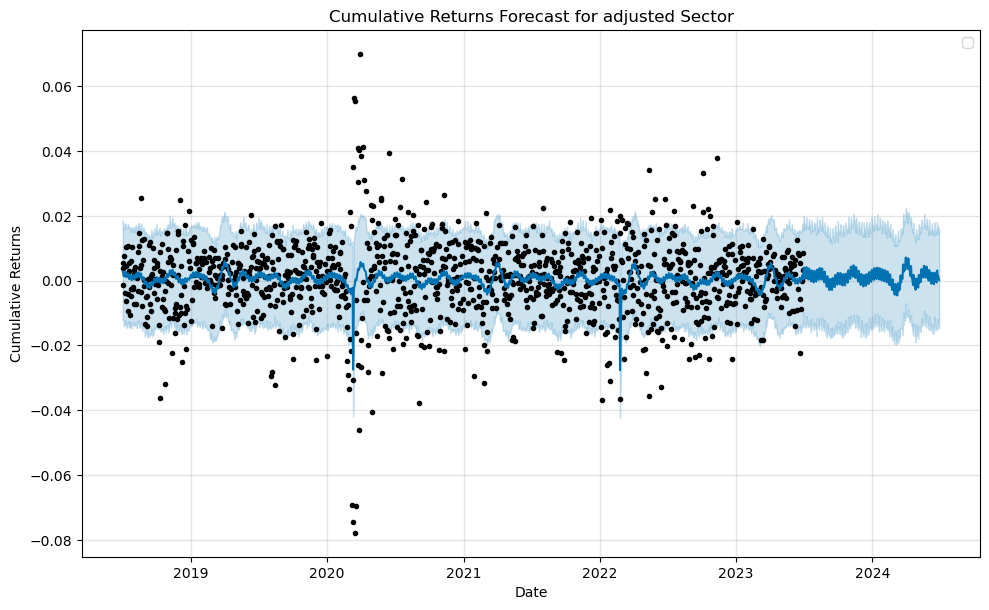

In [13]:
fig1 = (model.plot(forecast),
    plt.legend(),
    plt.title("Cumulative Returns Forecast for adjusted Sector"),
    plt.xlabel("Date"),
    plt.ylabel("Cumulative Returns")
       )

<Figure size 1000x600 with 0 Axes>

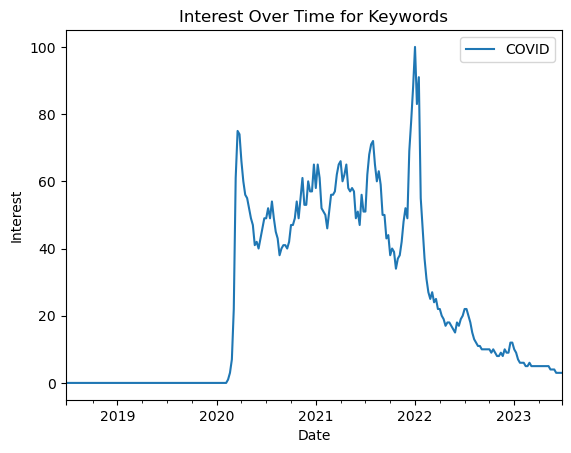

In [43]:


# Set up pytrends
pytrends = TrendReq(hl="en-US", tz=360)

# Keywords to track
keywords = ["COVID"]

# Build the payload
pytrends.build_payload(keywords, timeframe="2018-07-01 2023-06-30", geo="")

# Get interest over time data
interest_over_time_df = pytrends.interest_over_time()

# Plot the data
sentiment_plot = (plt.figure(figsize=(10, 6)),
    interest_over_time_df.plot(),
    plt.title("Interest Over Time for Keywords"),
    plt.xlabel("Date"),
    plt.ylabel("Interest"),
)


In [44]:
print(interest_over_time_df)

            COVID  isPartial
date                        
2018-07-01      0      False
2018-07-08      0      False
2018-07-15      0      False
2018-07-22      0      False
2018-07-29      0      False
...           ...        ...
2023-05-28      4      False
2023-06-04      3      False
2023-06-11      3      False
2023-06-18      3      False
2023-06-25      3      False

[261 rows x 2 columns]


In [45]:
# Resample daily data into weekly frequency and calculate the mean
weekly_average = final_portfolio.resample('W').mean()
print(weekly_average)

Date
2018-07-08    0.003860
2018-07-15    0.001417
2018-07-22    0.001052
2018-07-29   -0.000240
2018-08-05   -0.001245
                ...   
2023-06-04    0.001815
2023-06-11   -0.001981
2023-06-18    0.002279
2023-06-25   -0.004668
2023-07-02    0.003011
Freq: W-SUN, Length: 261, dtype: float64


In [46]:
##replacing zeroes to negative infinity and beyond
interest_over_time_df["COVID"] = interest_over_time_df["COVID"].replace(0, 1)
interest_over_time_df

interest_over_time_df[interest_over_time_df["COVID"] == 0]



,COVID,isPartial
date,,


In [47]:

covid_sentiment_change = interest_over_time_df["COVID"].pct_change()
covid_sentiment_change

date
2018-07-01     NaN
2018-07-08    0.00
2018-07-15    0.00
2018-07-22    0.00
2018-07-29    0.00
              ... 
2023-05-28    0.00
2023-06-04   -0.25
2023-06-11    0.00
2023-06-18    0.00
2023-06-25    0.00
Name: COVID, Length: 261, dtype: float64

In [48]:
covid_sentiment_change_drop = covid_sentiment_change.dropna()
covid_sentiment_change_drop


date
2018-07-08    0.00
2018-07-15    0.00
2018-07-22    0.00
2018-07-29    0.00
2018-08-05    0.00
              ... 
2023-05-28    0.00
2023-06-04   -0.25
2023-06-11    0.00
2023-06-18    0.00
2023-06-25    0.00
Name: COVID, Length: 260, dtype: float64

In [49]:
combined_data = pd.concat([weekly_average, covid_sentiment_change_drop], axis=1)
combined_data = combined_data.dropna()
combined_data.reset_index(inplace=True)
combined_data

,index,0,COVID
0,2018-07-08,0.003860,0.00
1,2018-07-15,0.001417,0.00
2,2018-07-22,0.001052,0.00
3,2018-07-29,-0.000240,0.00
4,2018-08-05,-0.001245,0.00
...,...,...,...
255,2023-05-28,-0.000309,0.00
256,2023-06-04,0.001815,-0.25
257,2023-06-11,-0.001981,0.00
258,2023-06-18,0.002279,0.00


<Axes: >

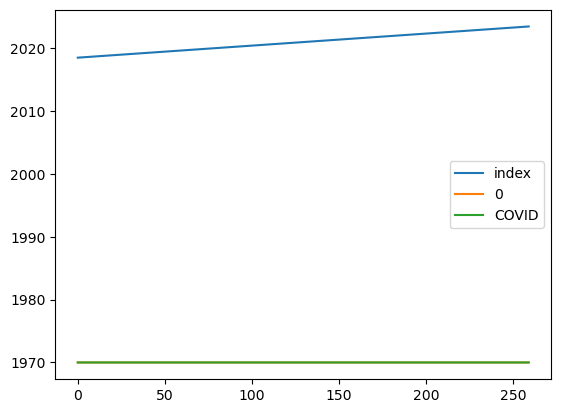

In [50]:
combined_data.plot()

In [51]:
correlation = combined_data [0].corr(combined_data['COVID'])
print(correlation)

-0.23879438374074113


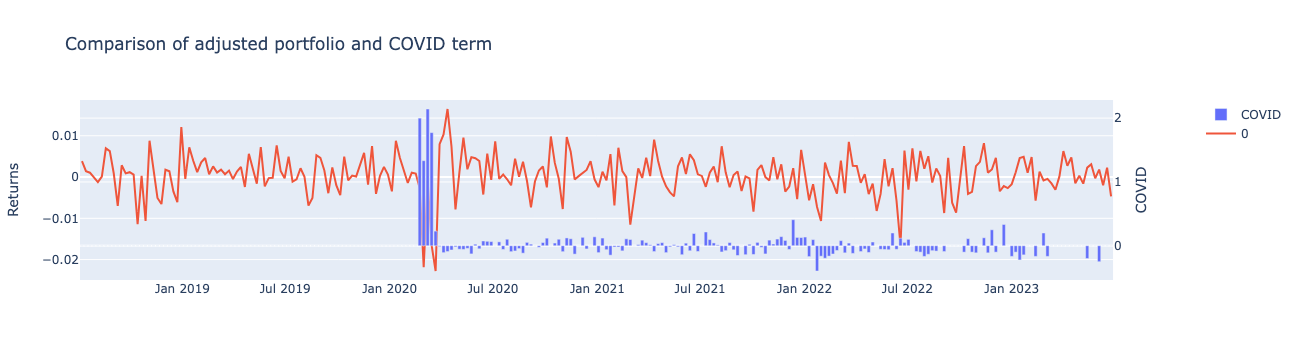

In [52]:
correlation_plot = make_subplots(rows=1, cols=1, shared_xaxes=True, specs=[[{'secondary_y': True}]])

#Add bar plot plot for the covid term frequencies
correlation_plot.add_trace(go.Bar(x=combined_data['index'], y=combined_data['COVID'], name='COVID'), secondary_y=True)

correlation_plot.add_trace(go.Scatter(x=combined_data['index'], y=combined_data[0], mode='lines', name=0), secondary_y=False)

correlation_plot.update_layout(title='Comparison of adjusted portfolio and COVID term')

correlation_plot.update_yaxes(title_text='COVID', secondary_y=True)
correlation_plot.update_yaxes(title_text='Returns', secondary_y=False)

correlation_plot.show()